# Table of contents
- [Table of contents](#table-of-contents)
- [Imports](#imports)
  - [Flags](#flags)
- [Preprocessing](#preprocessing)
  - [Functions](#functions-preprocessing)
  - [Primary](#primary-preprocessing)
- [Clustering](#clustering)
  - [Functions](#functions-clustering)
  - [DBSCAN](#dbscan)
  - [PCA](#pca)
  - [Agglomerative Clustering](#agglomerative-clustering)
  - [SOM](#som)
- [Testing](#testing)

## Imports

In [ ]:
import skimage as ski
import numpy as np
import os 

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from minisom import MiniSom

from sklearn.decomposition import PCA
from sklearn.metrics.cluster import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering

%matplotlib inline

## Flags
[To the top](#table-of-contents)

In [ ]:
# FLAGS 
FILTER_IMAGES = True
PREPROCESS_IMAGES = True
VERBOSE = True
VERBOSE_FUNCTIONS = False
# Check if the folder, images_training_subfolder31, exists
FOLDER_OF_INTEREST = "images_training_subfolder31"
FOLDER_OF_PREPPED_IMAGES = "prepped_images"


## Preprocessing and data transformation
### Functions Preprocessing
[To the top](#table-of-contents)

In [ ]:
class Galaxy:
    def __init__(self, x, y, sigma):
        self._x = x
        self._y = y
        self._sigma = sigma
    
    @property
    def center(self):
        return [self._x, self._y]
    
    @property
    def radius(self):
        factor = np.sqrt(2)
        return factor*self._sigma


In [ ]:
def get_image_path(galaxyID, test_true=False, train_true=False):
    if galaxyID is None:
        return None
    if isinstance(galaxyID, int):
        galaxyID = str(galaxyID)
    # Get the current working directory
    current_dir = os.getcwd()
    # Search through the subfolders for the image with the same ID
    search_dir = current_dir
    for root, dirs, files in os.walk(search_dir):
        for file in files:
            if file.startswith(galaxyID) and file.endswith('.jpg'):
                return os.path.join(root, file)

    # If the image is not found, return None
    return None


In [ ]:

def cropp_image(image, center_x, center_y, radius):
    return image[int(center_x-radius):int(center_x+radius), int(center_y-radius):int(center_y+radius)]


In [ ]:

def overlap(image, galaxy1:Galaxy, galaxy2:Galaxy, verbose=False):
    top_galaxy, bottom_galaxy = (galaxy1, galaxy2) if galaxy1.center[1] > galaxy2.center[1] else (galaxy2, galaxy1) 
    # top_galaxy will be the one most to the bottom of the pictures
    # This is because of the pixel coordinates, where the y-axis is inverted
    
    D = np.sqrt((top_galaxy.center[0]-bottom_galaxy.center[0])**2 + (top_galaxy.center[1]-bottom_galaxy.center[1])**2)
    alpha = np.arcsin((top_galaxy.center[0]-bottom_galaxy.center[0])/D)

    if top_galaxy.center[0] < bottom_galaxy.center[0]:
        alpha = np.pi/2+alpha
    else:
        alpha = np.pi/2+alpha

    closest_point = [int(top_galaxy.center[0] + top_galaxy.radius*np.cos(alpha)), int(top_galaxy.center[1] - top_galaxy.radius*np.sin(alpha))]
    if verbose:
        print(f"Closest point: {closest_point}")
        print(f"Distance: {D}")
        print(f"Alpha: {alpha/np.pi*180} degrees")
        print(f"Top Galaxy center: {top_galaxy.center}")
        print(f"Bottom Galaxy center: {bottom_galaxy.center}")

        #plot the two galaxies
        ski.io.imshow(image)
        plt.plot(top_galaxy.center[0], top_galaxy.center[1], 'go')
        plt.plot(bottom_galaxy.center[0], bottom_galaxy.center[1], 'go')
        #plot the closest point onto the image
   
        plt.plot(closest_point[0], closest_point[1], 'ro')
        
        plt.plot([top_galaxy.center[0], bottom_galaxy.center[0]], [top_galaxy.center[1], bottom_galaxy.center[1]], 'r-')
        plt.show()
    if np.sqrt((closest_point[0]-bottom_galaxy.center[0])**2 + (closest_point[1]-bottom_galaxy.center[1])**2) < bottom_galaxy.radius:
        return True
    else:
        return False


In [ ]:

def find_galaxy(image, window, verbose=False):
    blobs = ski.feature.blob_doh(image,
                                threshold=0.004, 
                                max_sigma = 100,
                                overlap=1)
    if verbose:
        print(blobs)
    image_center = [image.shape[0]//2, image.shape[1]//2]
    found_galaxy = None
    largest_sigma = 0
    blobs_in_window = []
    for b in blobs:
        if all(abs(b[i] - image_center[i]) < window for i in range(2)) and b[2] > largest_sigma:
            blobs_in_window.append(b)
            largest_sigma = b[2]
            found_galaxy = b

    if found_galaxy is None:
        return None
        
    found_galaxy = Galaxy(found_galaxy[1], found_galaxy[0], found_galaxy[2])

    for b in blobs:
        blob = Galaxy(b[1], b[0], b[2])
        if blob.center != found_galaxy.center:
            # Check if they overlap
            if overlap(image, found_galaxy, blob, verbose=verbose):
                if verbose:
                    print(f"There is overlap between {found_galaxy.center} and {blob.center}")
                return False
    return found_galaxy
            

In [ ]:
def check_for_black_stripe(image, verbose=False):
    # If there is at least 10 dark pixels in a row of any angle that are surrounded by light pixels, then there is a black stripe
    # image is cropped and gray scaled

    dark_pixel_threshold = 0.1
    dark_pixel_count_threshold = 15
    bright_pixel_threshold = 0.2

    dark_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < dark_pixel_threshold:
                dark_pixels.append([i,j])
    
    bright_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > bright_pixel_threshold:
                bright_pixels.append([i,j])


    suspicious_pixels = []
    # Look at a window around each dark pixel
    # If the mean of the pixels in the window is above the bright pixel threshold, add it to the list of suspicious pixels
    for pixel in dark_pixels:
        window = 5
        window_pixels = []
        for i in range(pixel[0]-window, pixel[0]+window):
            for j in range(pixel[1]-window, pixel[1]+window):
                if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                    window_pixels.append(image[i][j])
        if np.mean(window_pixels) > bright_pixel_threshold:
            suspicious_pixels.append(pixel)

    #Plot the dark pixels onto the image
    if verbose:
        ski.io.imshow(image)
        
        for pixel in bright_pixels:
            plt.plot(pixel[1], pixel[0], 'bo')
        for pixel in dark_pixels:
            plt.plot(pixel[1], pixel[0], 'ro')
        for pixel in suspicious_pixels:
            plt.plot(pixel[1], pixel[0], 'go')
        plt.show()

    # How many suspicious pixels are there?
    if len(suspicious_pixels) > dark_pixel_count_threshold:
        # Do linear regression on the suspicious pixels
        # If the R^2 value is high, then there is a black stripe

        # Get the x and y values of the suspicious pixels
        x = []
        y = []
        for pixel in suspicious_pixels:
            x.append(pixel[0])
            y.append(pixel[1])
        # Do linear regression with numpy
        slope, intercept = np.polyfit(x, y, 1)
        #Plot the line
        if verbose:
            plt.plot(x, y, 'ro')
            plt.plot(x, [slope*x[i] + intercept for i in range(len(x))], 'b')
            plt.show()
        # Get the R^2 value
        r_squared = np.corrcoef(x, y)[0,1]**2
        # If the R^2 value is high, then there is a black stripe
        print(f"R^2 = {r_squared}")
        if r_squared > 0.3:
            print("Black Stripe found")
            return True
        else:
            print("Black Stripe was not found")
            return False
    else:
        return False

In [ ]:
def get_covariance_matrix(image, x_size, y_size):
    coord_rows = []
    coord_columns = []
    for index_row in range(0, x_size):
        for index_column in range(0, y_size):
            if image[index_row][index_column] == 1:
                coord_rows.append(index_row)
                coord_columns.append(index_column)
    cov_matrix = np.cov(coord_rows, y=coord_columns)
    return cov_matrix

In [ ]:



def get_rotation_on_image(image, verbose=False):
    binary_image = ski.util.img_as_bool(image)
    if verbose:
        ski.io.imshow(binary_image)
        pass
    
    cov_matrix = get_covariance_matrix(binary_image, len(binary_image), len(binary_image[0]))
    
    if verbose:
        print(f"cov_matrix[0] = \t[{cov_matrix[0][0]}, {cov_matrix[0][1]}]")
        print(f"cov_matrix[1] = \t[{cov_matrix[1][0]}, {cov_matrix[1][1]}]")
    result = np.linalg.eigh(cov_matrix)
    eigenvalues = result[0]
    eigenvectors = result[1]

    
    max_eigen_index, = np.where(np.isclose(eigenvalues, max(eigenvalues)))[0]
    if verbose:
        print(f"Eigenvalues     = \t[{eigenvalues[0]}, {eigenvalues[1]}]")
        print(f"eigenvectors[0] = \t[{eigenvectors[0][0]}, {eigenvectors[0][1]}]")
        print(f"eigenvectors[1] = \t[{eigenvectors[1][0]}, {eigenvectors[1][1]}]")
        print(eigenvectors[max_eigen_index][0])
        print(eigenvectors[(max_eigen_index+1)%2][1])
    rotations_in_radians = np.arccos((eigenvectors[max_eigen_index][0]+eigenvectors[(max_eigen_index+1)%2][1]) / 2)
    rotation_in_degrees = np.rad2deg(rotations_in_radians)
    if rotation_in_degrees > 90:
        rotation_in_degrees = 180 - rotation_in_degrees


    if (eigenvectors[max_eigen_index][0] * eigenvectors[max_eigen_index][1]) > 0:
        rotation_in_degrees = -rotation_in_degrees

    if verbose:
        print("Rotating images with the deg", rotation_in_degrees)
        # ski.io.imshow(ski.transform.rotate(image, rotation_in_degrees))

    return rotation_in_degrees+90


In [ ]:

def filter_image(img, verbose=False):
    """
    Very simple function that is only supposed to use already existing functions with minimal interaction to handle a picture.
    
    It should return true if it's filtered out and false if it's not.
    """
    gray_img = ski.color.rgb2gray(img)
    galaxy = find_galaxy(gray_img, window=50, verbose=verbose) 
    if galaxy is None or galaxy is False:
        return True
    
    cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
    cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
    return_value = check_for_black_stripe(cropped_exposed_img, verbose=verbose) ## Not implemented
    if return_value is True:
        return True
        
    return galaxy


In [ ]:

def preprocess_image(img, galaxy, verbose=False):
    """
    Function that should handle the image and return a cropped and rotated image.
    """  
    gray_img = ski.color.rgb2gray(img)  
    cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
    cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
    angle = get_rotation_on_image(cropped_exposed_img, verbose=verbose)
    rotated_image = ski.transform.rotate(gray_img, angle)
    cropped_rotated_img = cropp_image(rotated_image, galaxy.center[0], galaxy.center[1], galaxy.radius)
    resized_cropped_rotated_image = ski.transform.resize(cropped_rotated_img, (128, 128))
    resized_cropped_rotated_image = ski.exposure.rescale_intensity(resized_cropped_rotated_image)
    return resized_cropped_rotated_image


## Primary-Preprocessing
- [To the top](#table-of-contents)

Image passed filter
Image was preprocessed
Image[27]
Image passed filter
Image was preprocessed
Image[28]
R^2 = 0.44603789658146437
Black Stripe found
Image[28] was filtered out
Image[29]
Image[29] was filtered out
Image[30]


KeyboardInterrupt: 

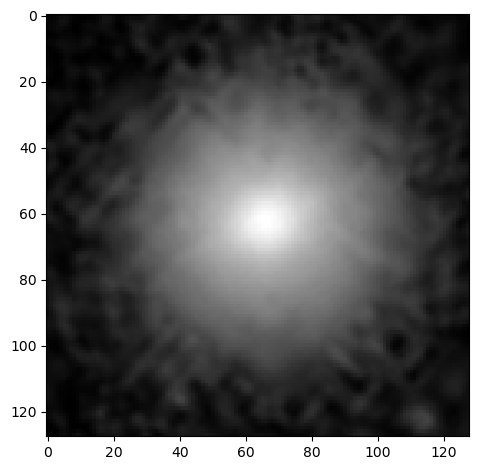

In [32]:

if not os.path.isdir(FOLDER_OF_INTEREST):
    print(f"The folder {FOLDER_OF_INTEREST} does not exist. Please download from the Kaggle website and split if needed.")
    raise SystemExit

if not os.path.isdir(f"./{FOLDER_OF_PREPPED_IMAGES}/{FOLDER_OF_INTEREST}"):
    os.mkdir(f"./{FOLDER_OF_PREPPED_IMAGES}/{FOLDER_OF_INTEREST}")

image_collection = ski.io.imread_collection(f"./{FOLDER_OF_INTEREST}/*.jpg", conserve_memory=True)

for index, image in enumerate(image_collection):
    name = image_collection.files[index].split("/")[-1].split(".")[0]
    if VERBOSE:
        print(f"Image[{index}]")

    if FILTER_IMAGES:
        return_value = filter_image(image, VERBOSE_FUNCTIONS) 
        if return_value is True:
            if VERBOSE:
                print(f"Image[{index}] was filtered out")
            continue 
    galaxy = return_value
    
    if VERBOSE:
        print("Image passed filter")

    if PREPROCESS_IMAGES:
        preprocessed_image = preprocess_image(image, galaxy, VERBOSE_FUNCTIONS)
        # Send image to prepped_images folder
        # Make it a tiff file
        image = ski.img_as_ubyte(preprocessed_image)
        # If the folder does not exist, create it
        if not os.path.isdir(f"./prepped_images/{FOLDER_OF_INTEREST}"):
            os.mkdir(f"./prepped_images/{FOLDER_OF_INTEREST}")
        ski.io.imsave(f"./prepped_images/{FOLDER_OF_INTEREST}/{name}.tiff", image)

    if VERBOSE:
        print("Image was preprocessed")
        ski.io.imshow(preprocessed_image)

## Clustering
Now, we have a dataset of images with one galaxy in the middle. Next step is to work with the data and cluster it.

[To the top](#table-of-contents)


### Functions Clustering


In [ ]:
def flatten(image):
    flattened_image = []
    for row in image:
        for pixel in row:
            flattened_image.append(pixel)
    # Scale to between 0 and 10 from 0 and 255
    flattened_image = np.array(flattened_image)
    flattened_image = flattened_image/255
    return flattened_image


### DBSCAN




In [ ]:
# Handling model training
FOLDER_OF_INTEREST = "prepped_images/images_training_subfolder31"
image_collection = ski.io.imread_collection(f"./{FOLDER_OF_INTEREST}/*.tiff", conserve_memory=True)

if VERBOSE:
    print(f"Number of images: {len(image_collection)}")

if len(image_collection) == 0:
    print(f"There are no images in the folder {FOLDER_OF_INTEREST}. Please run the preprocessing script first.")
    raise SystemExit

flattend_images = [ flatten(image) for image in image_collection ]
flattend_images = np.concatenate(flattend_images, axis=0)
flattend_images = flattend_images.reshape(len(image_collection), -1)
# Check that all images have the same number of features
for index, image in enumerate(flattend_images):
    if index == 0:
        number_of_features = len(image)
    else:
        if len(image) != number_of_features:
            print(f"Image {index} has a different number of features than the first image")
            raise SystemExit

if VERBOSE:
    print(f"Number of features: {number_of_features}")

eps_values = [5, 10, 15, 20, 25, 100, 250, 500]
min_samples_values = [10, 50, 100, 150, 250, 500]
try:
    for eps in eps_values: 
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = dbscan.fit_predict(flattend_images)

            outliers = 0

            for index, label in enumerate(labels):
                if label == -1:
                    if VERBOSE:
                        print(f"Outlier | Too much noise in the image{index}")
                    outliers += 1

            if VERBOSE:
                print(f"Number of outliers: {outliers}")
                print(f"Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
except:
    print("Something went wrong")
    raise SystemExit


### PCA

In [ ]:
images = ski.io.imread_collection(f"./prepped_images/images_training_subfolder3/*.tiff", conserve_memory=True)
images2 = ski.io.imread_collection(f"./prepped_images/images_training_subfolder31/*.tiff", conserve_memory=True)

images_1d_mapped = {}
for index, image in enumerate(images):
    name = images.files[index].split("/")[-1].split(".")[0]
    images_1d_mapped[name]=image.flatten()
for index, image in enumerate(images2):
    name = images2.files[index].split("/")[-1].split(".")[0]
    images_1d_mapped[name]=image.flatten()

images_as_array = np.vstack(list(images_1d_mapped.values()))
# Scale the data between 0 and 1
images_as_array = images_as_array / 255

if VERBOSE:
    print(f"Number of images: {len(images_as_array)}")
    print(f"Number of features: {len(images_as_array[0])}")
    print(f"Shape of images_as_array: {images_as_array.shape}")

In [ ]:
# Do PCA
pca = PCA(n_components=200)
pca.fit(images_as_array)

images_as_pca = pca.transform(images_as_array)

if VERBOSE:
    print(f"Shape of images_as_pca: {images_as_pca.shape}")

### Agglomerative clustering

Do Hierarchical clustering, and see if we can find some clusters.

In [ ]:
# Create a AgglomerativeClustering object
ms = AgglomerativeClustering(n_clusters=None, linkage="ward", distance_threshold=100)

# Train the model
ms.fit(images_as_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
#cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))
if VERBOSE:
    print("Number of estimated clusters:", n_clusters_)

#How many images are in each cluster?
unique, counts = np.unique(labels, return_counts=True)
if VERBOSE:
    print(dict(zip(unique, counts)))

    print("\n\n\n")

    print("Silhouette Coefficient: %0.3f"
        % silhouette_score(images_as_array, labels))    # Is this correct? Shoulnd't it be images_as_pca?
    print("Davis-Bouldin Index: %0.3f"
        % davies_bouldin_score(images_as_array, labels))
    print("Calinski-Harabasz Index: %0.3f"
        % calinski_harabasz_score(images_as_array, labels))

In [ ]:
# Plot example images from each cluster
# All the images from the same cluster are in the same row
# The images are randomly selected from the cluster

# Get the indices of the images in each cluster
indices = []
for i in range(n_clusters_):
    indices.append([])
for i in range(len(labels)):
    indices[labels[i]].append(i)

# Plot the images
for i in range(n_clusters_):
    if len(indices[i]) < 10:
        continue
    plt.figure(figsize=(20, 1))
    #Add the title
    plt.suptitle(f"Cluster {i}")
    for j in range(20):
        plt.subplot(1, 20, j+1)
        plt.axis('off')
        plt.imshow(images_as_array[indices[i][np.random.randint(0, len(indices[i]))]].reshape(128, 128), cmap="gray")
    plt.show()

In [ ]:
# Now, plot again, but the real images
# Get the indices of the images in each cluster
indices = []
for i in range(n_clusters_):
    indices.append([])
for i in range(len(labels)):
    indices[labels[i]].append(i)

# Plot the images
for i in range(n_clusters_):
    if len(indices[i]) < 10:
        continue
    plt.figure(figsize=(10, 1))
    #Add the title
    plt.suptitle(f"Cluster {i}")
    for j in range(10):
        random_index = np.random.randint(0, len(indices[i]))
        #Find the image
        image_index = indices[i][random_index]
        # Find the filename
        name = list(images_1d_mapped.keys())[image_index]
        # Load the image
        image = ski.io.imread(get_image_path(name))
        plt.subplot(1, 10, j+1)
        plt.axis('off')
        plt.imshow(image)
    plt.show()

### SOM 
- [To the top](#table-of-contents)
This is good and all, but if we can use SOM (Self-organizing maps) we can get a 2D representation of the data with very high dimensionality. 

In [ ]:

# Do PCA, but with 25 components to keep processing time down
pca = PCA(n_components=25)
pca.fit(images_as_array)

images_as_pca_for_som = pca.transform(images_as_array)

#Do Self Organising Maps the images to extract features
# Works well with PCA 25 components
# Do SOM on the images
array = images_as_pca_for_som
som = MiniSom(int(10*np.sqrt(array.shape[0])), int(10*np.sqrt(array.shape[0])), array.shape[1], sigma=50, learning_rate=0.1, topology="rectangular", random_seed=10)
som.train(array, 1000)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

for i, x in enumerate(array):
    w = som.winner(x)
    plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='None', markersize=1, markeredgecolor='r', markeredgewidth=0.2)

plt.show()

In [ ]:
# Transform the images into the SOM space
features = []
for x in array:
    w = som.winner(x)
    features.append(w)
features = np.array(features)

# Cluster with Agglomerative Clustering
ms = AgglomerativeClustering(n_clusters=None, linkage="average", distance_threshold=100)

# Train the model
ms.fit(features)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
#cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))
if VERBOSE:
    print("Number of estimated clusters:", n_clusters_)

#How many images are in each cluster?
unique, counts = np.unique(labels, return_counts=True)
if VERBOSE:
    print(dict(zip(unique, counts)))

# Plot the clusters on a 2d plane
plt.figure(figsize=(10, 10))
plt.scatter(features[:,0], features[:,1], c=labels.astype(float))
#Plot the labels
for i, txt in enumerate(labels):
    plt.annotate(txt, (features[i,0], features[i,1]))
plt.show()

#Metrics score for SOM implementation
if VERBOSE:
    print("Silhouette Coefficient: %0.3f"
        % silhouette_score(features, labels))
    print("Davis-Bouldin Index: %0.3f"
        % davies_bouldin_score(features, labels))
    print("Calinski-Harabasz Index: %0.3f"
        % calinski_harabasz_score(features, labels))

In [ ]:
# Plot ten images from each cluster
# All the images from the same cluster are in the same row
# The images are randomly selected from the cluster

# Get the indices of the images in each cluster
indices = []
for i in range(n_clusters_):
    indices.append([])
for i in range(len(labels)):
    indices[labels[i]].append(i)

# Plot the images
for i in range(n_clusters_):
    plt.figure(figsize=(20, 20))
    for j in range(20):
        plt.subplot(1, 20, j+1)
        plt.axis('off')
        plt.imshow(images_as_array[indices[i][np.random.randint(0, len(indices[i]))]].reshape(128, 128), cmap="gray")
    plt.show()

# Testing 
[To the top](#table-of-contents)

In [ ]:


# img = ski.io.imread(get_image_path(747207))
# img = ski.io.imread(get_image_path(262909))
# img = ski.io.imread(get_image_path(312941)) ##outlier, don't change
# img = ski.io.imread(get_image_path(732356))
# img = ski.io.imread(get_image_path(101151)) ##irregular
# img = ski.io.imread(get_image_path(458590)) ## long
# img = ski.io.imread(get_image_path(459014)) ##overlap
# img = ski.io.imread(get_image_path(856044)) ##overlap
# img = ski.io.imread(get_image_path(856535)) ##overlap
# img = ski.io.imread(get_image_path(100295)) ##black stripe
# img = ski.io.imread(get_image_path(856758)) ##black stripe
# img = ski.io.imread(get_image_path(775905)) ##very inactive galaxy
# img = ski.io.imread(get_image_path(744265)) ##very bright background
# img = ski.io.imread(get_image_path(100008))
